In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import string

In [3]:
# Load the dataset
# using 'latin-1' encoding as the dataset contains special characters
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')
except UnicodeDecodeError:
    df = pd.read_csv('spam.csv', encoding='utf-8')

# Display first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# 1. Drop unnecessary columns
# The dataset often has 3 extra empty columns, we drop them
drop_cols = [col for col in df.columns if 'Unnamed' in col]
df = df.drop(columns=drop_cols)

In [5]:
# 2. Rename columns for better understanding
# v1 -> target (ham/spam), v2 -> text (message)
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [6]:
# 3. Encode the target variable
# 'ham' becomes 0, 'spam' becomes 1
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [7]:
# 4. Check for and remove duplicates
print(f"Duplicates before removing: {df.duplicated().sum()}")
df = df.drop_duplicates(keep='first')
print(f"Duplicates after removing: {df.duplicated().sum()}")

Duplicates before removing: 403
Duplicates after removing: 0


In [8]:
# 5. Verify the data after cleaning
print("\nCleaned Data Info:")
print(df.info())
display(df.head())


Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5169 non-null   int64 
 1   text    5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB
None


,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


C:\Users\Ghulam Mustafa\AppData\Local\Temp\ipykernel_10292\2354796304.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


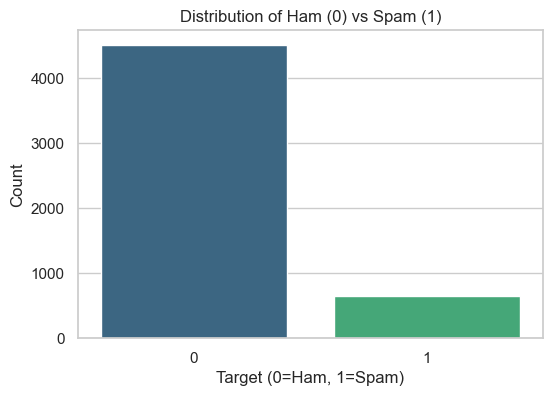

In [9]:
# Set plot style
sns.set(style="whitegrid")

# 1. Distribution of Target (Spam vs Ham)
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribution of Ham (0) vs Spam (1)')
plt.xlabel('Target (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.show()

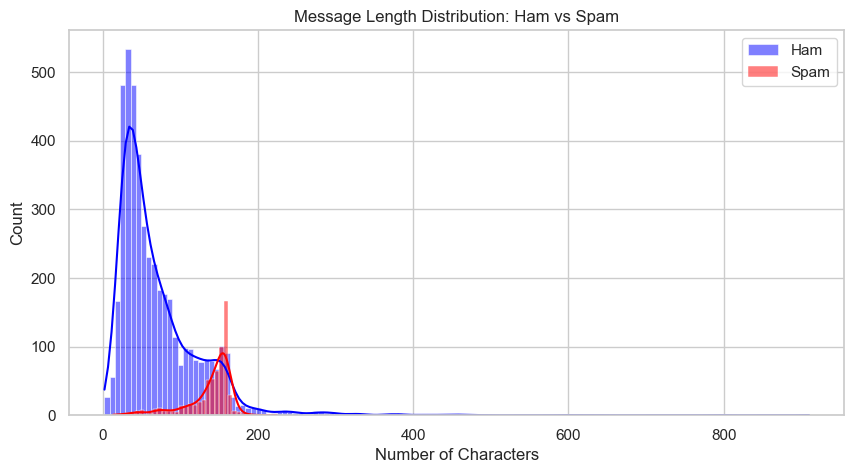

In [10]:
# 2. Feature Engineering: Message Length
# Create a new column 'num_characters'
df['num_characters'] = df['text'].apply(len)

# Plot length distribution
plt.figure(figsize=(10, 5))
sns.histplot(df[df['target'] == 0]['num_characters'], color='blue', label='Ham', kde=True)
sns.histplot(df[df['target'] == 1]['num_characters'], color='red', label='Spam', kde=True)
plt.legend()
plt.title('Message Length Distribution: Ham vs Spam')
plt.xlabel('Number of Characters')
plt.show()


In [11]:
print("\nSummary Statistics for Message Length:")
print(df.groupby('target')['num_characters'].describe())


Summary Statistics for Message Length:
         count        mean        std   min    25%    50%    75%    max
target                                                                 
0       4516.0   70.459256  56.358207   2.0   34.0   52.0   90.0  910.0
1        653.0  137.891271  30.137753  13.0  132.0  149.0  157.0  224.0


In [12]:
# Function to clean text
def transform_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove punctuation
    # string.punctuation contains symbols like !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    text = "".join([char for char in text if char not in string.punctuation])
    
    return text

# Apply the function to the text column
df['transformed_text'] = df['text'].apply(transform_text)

# Display the original vs transformed text
print("Original vs Transformed Text:")
display(df[['text', 'transformed_text']].head())

Original vs Transformed Text:


,text,transformed_text
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [13]:
# Initialize TF-IDF Vectorizer
# max_features=3000 keeps the top 3000 most frequent words
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

# Fit and transform the text data
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

print("Shape of Feature Matrix (X):", X.shape)
print("Shape of Target Vector (y):", y.shape)

Shape of Feature Matrix (X): (5169, 3000)
Shape of Target Vector (y): (5169,)


In [14]:
# Split the data into training and testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Multinomial Naive Bayes model
mnb = MultinomialNB()

# Train the model
mnb.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


Accuracy: 97.29%

Confusion Matrix:


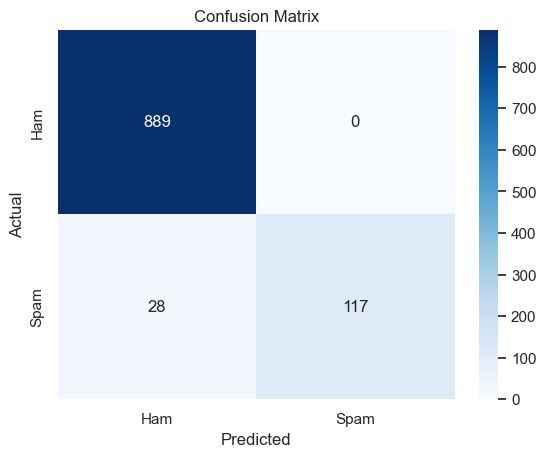

In [16]:
# Make predictions
y_pred = mnb.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       889
        Spam       1.00      0.81      0.89       145

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.94      1034
weighted avg       0.97      0.97      0.97      1034



In [18]:
# Function to predict single message
def predict_spam(message):
    # 1. Preprocess
    transformed_message = transform_text(message)
    # 2. Vectorize
    vector_input = tfidf.transform([transformed_message])
    # 3. Predict
    result = mnb.predict(vector_input)[0]
    
    if result == 1:
        return "Spam"
    else:
        return "Not Spam (Ham)"

# Test with examples
sample_email_1 = "Congratulations! You've won a free ticket to the Bahamas. Text WIN to 12345."
sample_email_2 = "Hey, are we still meeting for lunch tomorrow?"

print(f"Message: '{sample_email_1}' -> Prediction: {predict_spam(sample_email_1)}")
print(f"Message: '{sample_email_2}' -> Prediction: {predict_spam(sample_email_2)}")

Message: 'Congratulations! You've won a free ticket to the Bahamas. Text WIN to 12345.' -> Prediction: Spam
Message: 'Hey, are we still meeting for lunch tomorrow?' -> Prediction: Not Spam (Ham)
